In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 12, 10

In [ ]:
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

import statsmodels.api as sm
from scipy import stats
from itertools import product
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_absolute_error


In [111]:
with open('data_series_one.pickle', 'rb') as ts:
    timeseries = pickle.load(ts)
timeseries = np.array(timeseries).reshape(-1)

In [ ]:
len(timeseries)-5000

In [ ]:
timeseries = timeseries[len(timeseries)-5000:]
timeseries

In [ ]:
plt.plot(ts)

In [ ]:
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=3000))

input_data = InputData(idx=np.arange(0, len(timeseries)),
                       features=timeseries, target=timeseries,
                       task=task, data_type=DataTypesEnum.ts)

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

СКОЛЬЗЯЩЕЕ СРЕДНЕЕ


In [ ]:
moving_average = PrimaryNode('smoothing')
moving_average.custom_params = {
                                'window_size': 25
                                }
moving_average_out = node_fit_predict(moving_average,input_data)

In [ ]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(moving_average_out.idx, moving_average_out.predict, label='Smoothed by 15 elements', linewidth=3)
plt.legend()
plt.show()

ФИЛЬТР ГАУССА

In [ ]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 10}

smoothed_gaussian = node_fit_predict(gaussian_node, input_data)
timeseries = smoothed_gaussian.predict

In [ ]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()

АВТОРЕГРЕССИЯ


In [ ]:
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=2000))

input_data = InputData(idx=np.arange(0, len(timeseries)),
                       features=timeseries, target=timeseries,
                       task=task, data_type=DataTypesEnum.ts)

In [ ]:
len(input_data.target)

In [ ]:
train, test = train_test_data_setup(input_data)

In [ ]:
len(train.features)

In [ ]:
pipeline = Pipeline(PrimaryNode('ar'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=200, timeout=5,
                                        cv_folds=3, validation_blocks=2)

In [ ]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast')
plt.grid()
plt.legend()
plt.savefig('AR.png',dpi=150)

АРИМА

In [ ]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 3)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

In [ ]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(timeseries, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
            continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
print(f'AIC value: {model.aic}')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
print(best_model.summary())

In [ ]:
pipeline_arima = Pipeline(PrimaryNode('arima'))
pipeline_arima = pipeline_arima.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=100, timeout=5,
                                        cv_folds=2, validation_blocks=2)

In [ ]:
fitted_vals = pipeline_arima.fit(train)
forecast = pipeline_arima.predict(test)

In [ ]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.grid()
plt.legend()
plt.show()

fedot auto pipeline

In [ ]:
from fedot.api.main import Fedot

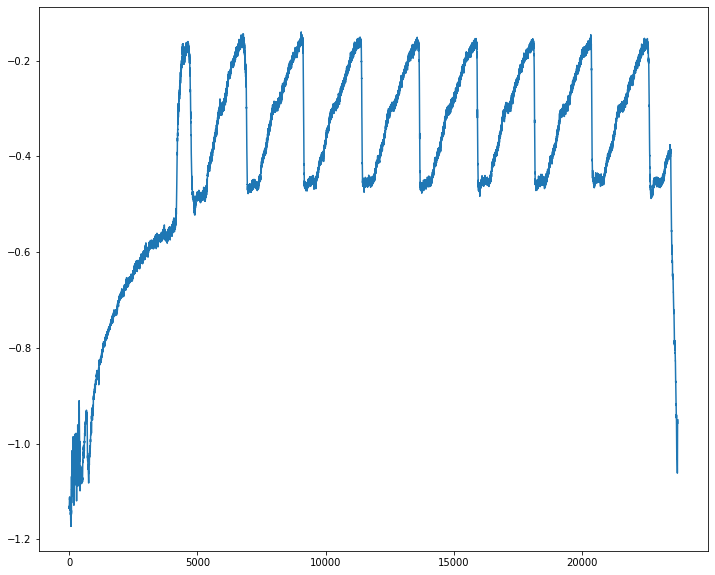

In [119]:
plt.plot(timeseries)

In [122]:
time_series = ts
warnings.filterwarnings('ignore')
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=3000))

train_input = InputData(idx=np.arange(0,len(time_series)),
                        features=time_series,
                        target=time_series,
                        task=task,
                        data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                task_params=task.task_params,
                timeout=5,
                preset='fast_train',
                n_jobs=-1)

# run AutoML model design in the same way
# print(train_data)
pipeline = model.fit(train_data)
pipeline.show()

# use model to obtain forecast
forecast = model.predict(test_data)
target = np.ravel(test_data.target)
print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'], target=target))

# plot forecasting result
model.plot_prediction()


свой пайплайн

In [ ]:
def get_decompose_pipeline():
    """ Create 4-level pipeline with decompose operation """

    node_lagged = PrimaryNode('lagged')
    node_dtreg = SecondaryNode('dtreg', nodes_from=[node_lagged])
    node_decompose = SecondaryNode('decompose', nodes_from=[node_lagged, node_dtreg])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_decompose])
    
    # Combining branches with different targets (T and T_decomposed)
    final_node = SecondaryNode('linear', nodes_from=[node_dtreg, node_lasso])
    pipeline = Pipeline(final_node)
    return pipeline


def get_simple_pipeline():
    """ Return simple non-linear pipeline lagged -> dtreg """
    node_lagged = PrimaryNode('lagged')
    final_node = SecondaryNode('dtreg', nodes_from=[node_lagged])
    pipeline = Pipeline(final_node)
    return pipeline


def wrap_into_input(forecast_length, time_series):
    """ Convert data for FEDOT framework """
    time_series = np.array(time_series)
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(time_series)),
                           features=time_series, target=time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data

In [ ]:
forecast_length = 3000
input_data = wrap_into_input(forecast_length=forecast_length, time_series=timeseries)

# Train test split
train, test = train_test_data_setup(input_data)

In [ ]:
len(test.features)

In [ ]:

decompose_pipeline = get_decompose_pipeline()
decompose_pipeline = decompose_pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=50, timeout=5,
                                        cv_folds=1, validation_blocks=2)
decompose_pipeline.fit(train)
decompose_prediction = decompose_pipeline.predict(test)


In [ ]:
simple_pipeline = get_simple_pipeline()
simple_pipeline = simple_pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                                      loss_params=None, input_data=train,
                                                      iterations=50, timeout=5,
                                                      cv_folds=2, validation_blocks=2)
simple_pipeline.fit(train)
simple_prediction = simple_pipeline.predict(test)

In [ ]:
plt.plot(input_data.idx, input_data.target, label='Actual time series')
plt.plot(decompose_prediction.idx, np.ravel(decompose_prediction.predict), label='Decompose forecast')
plt.plot(simple_prediction.idx, np.ravel(simple_prediction.predict), label='Non decompose forecast')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [ ]:
mae_decompose = mean_absolute_error(input_data.target[3000:],np.ravel(decompose_prediction.predict))
mae_simple = mean_absolute_error(input_data.target[3000:],np.ravel(simple_prediction.predict))
rmse_decompose = mean_squared_error(input_data.target[3000:],np.ravel(decompose_prediction.predict))
rmse_simple = mean_squared_error(input_data.target[3000:],np.ravel(simple_prediction.predict))
mape_decompose = mean_absolute_percentage_error(input_data.target[3000:],np.ravel(decompose_prediction.predict))
mape_simple = mean_absolute_percentage_error(input_data.target[3000:],np.ravel(simple_prediction.predict))
print('mae_decompose',mae_decompose)
print('mae_simple',mae_simple)
print('rmse_decompose',rmse_decompose)
print('rmse_simple',rmse_simple)
print('mape_decompose',mape_decompose)
print('mape_simple',mape_simple)

In [ ]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()

In [ ]:
from fedot.core.pipelines.ts_wrappers import out_of_sample_ts_forecast

# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=simple_pipeline,
                                         input_data=test,
                                         horizon=5000)

# Plot the graph
plot_results(actual_time_series = timeseries,
             predicted_values = ts_predicted, 
             len_train_data = len(timeseries)-3000)

In [ ]:
# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=test,
                                         horizon=5000)

# Plot the graph
plot_results(actual_time_series = timeseries,
             predicted_values = ts_predicted, 
             len_train_data = len(timeseries)-3000)